# CLV contractual settings in discrete time
Based on:<br>
[Probability Models for Customer-Base Analysis](https://brucehardie.com/talks/ho_cba_tut_art_09.pdf)<br>
[Fitting the sBG Model to Multi-Cohort Data](http://brucehardie.com/notes/017/sBG_estimation.pdf)

Hypothetical contractual setting:<br>
- Each contract is annual, starting on January 1 and expiring at 11:59pm on December 31.
- Constant average net cashflow.

What is the expected residual value of the customer base at December 31, 2007?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize
from scipy.special import hyp2f1

In [2]:
d = 0.1 # discount rate
v = 100 # yearly net CF

In [3]:
def rlv(v: float, d: float, r: float) -> float:
    """Computes E[RLV] of a single customer
    
    :param v: net CF
    :param d: annual discount rate
    :param r: annual retention rate
    
    :returns: E[RLV]
    """
    return v * (1 + d) * (r / (1 + d - r))

### Naive CLV

In [4]:
# we only know how many customers are there at the end of the year and how many of them are new
customers = pd.DataFrame(index=range(2003, 2008),
                         data={'new': [10_000, 10_000, 10_000, 10_000, 10_000],
                               'end_of_year': [10_000, 16_334, 20_701, 23_965, 26_569]}
                        )
customers

,new,end_of_year
2003,10000,10000
2004,10000,16334
2005,10000,20701
2006,10000,23965
2007,10000,26569


In [5]:
base_2007 = customers.loc[2007]['end_of_year']
acquired_2007 = customers.loc[2007]['new']
base_2006 = customers.loc[2006]['end_of_year']

In [6]:
r = (base_2007 - acquired_2007) / base_2006 # ratio of customers retained from 2006
RLV = 26_569 * rlv(v, d, r) # RLV as of December 31, 2007 assuming flat retention rate

print(f'RLV: {int(RLV)} \nretention ratio: {round(r, 2)}')

RLV: 4945049 
retention ratio: 0.69


### Heterogenity

In [7]:
# slightly richer data - we know which year each customer was acquired in
customers = pd.DataFrame(index=range(2003, 2008),
                         data={
                             '2003': [10_000, 0, 0, 0, 0],
                             '2004': [6_334, 10_000, 0, 0, 0],
                             '2005': [4_367, 6_334, 10_000, 0, 0],
                             '2006': [3_264, 4_367, 6_334, 10_000, 0],
                             '2007': [2_604, 3_264, 4_367, 6_334, 10_000]
                         }
                        )
customers

,2003,2004,2005,2006,2007
2003,10000,6334,4367,3264,2604
2004,0,10000,6334,4367,3264
2005,0,0,10000,6334,4367
2006,0,0,0,10000,6334
2007,0,0,0,0,10000


In [8]:
retention = (1 + customers.T.pct_change()).T
retention

,2003,2004,2005,2006,2007
2003,NaN,0.6334,0.689454,0.747424,0.797794
2004,NaN,inf,0.633400,0.689454,0.747424
2005,NaN,NaN,inf,0.633400,0.689454
2006,NaN,NaN,NaN,inf,0.633400
2007,NaN,NaN,NaN,NaN,inf


In [9]:
# additionally we assume we know there are only two underlying segments
# with simple and known distribution of retention rates:

# retention rate per segment
r1 = 0.9
r2 = 0.5
# probability of comming from given segment
p1 = 1 / 3
p2 = 1 - p1

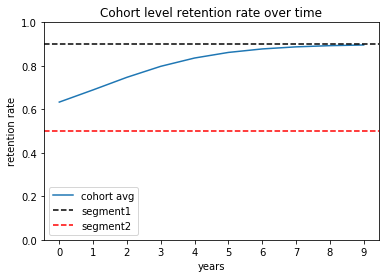

In [10]:
# demonstrates the effect of heterogenity in retention rates within each cohort
r = [(p1*(r1**(n+1)) + p2*(r2**(n+1))) / (p1*(r1**n) + p2*(r2**n)) for n in range(10)]

plt.plot(r, label='cohort avg')
plt.xticks(range(10))
plt.axhline(r1, linestyle='--', color='k', label='segment1')
plt.axhline(r2, linestyle='--', color='r', label='segment2')
plt.ylim(0,1)
plt.legend()
plt.title('Cohort level retention rate over time')
plt.xlabel('years')
plt.ylabel('retention rate')
plt.show()

In [11]:
base_2007 = customers.T.loc['2007'].sort_index(ascending=False)
base_2007

2007    10000
2006     6334
2005     4367
2004     3264
2003     2604
Name: 2007, dtype: int64

In [12]:
# probability of comming from segment 1 for customer acquired in given year (Bayes' rule)
p_segment1 = pd.Series(
    index=base_2007.index, 
    data=[(r1**n)*p1 / ((r1**n)*p1 + (r2**n)*p2) for n in range(5)]
)
p_segment1

2007    0.333333
2006    0.473684
2005    0.618321
2004    0.744637
2003    0.839969
dtype: float64

In [13]:
# the longer the relationship the higher the RLV (higher probability of comming from segment 1)
RLV_per_customer = pd.Series(
    index=base_2007.index,
    data=p_segment1 * rlv(v, d, r1) + (1-p_segment1) * rlv(v, d, r2)
)
RLV_per_customer

2007    226.111111
2006    282.719298
2005    341.055980
2004    392.003745
2003    430.454274
dtype: float64

In [14]:
RLV = pd.Series(
    index=base_2007.index,
    data=RLV_per_customer * base_2007
)
print(f'RLV: {int(RLV.sum())}')

RLV: 7941649


### Shifted Beta Geometric Model

In [15]:
v = 1
d = 0.1

In [16]:
customers = pd.DataFrame(index=range(2003, 2008),
                         data={
                             '2003': [10_000, 0, 0, 0, 0],
                             '2004': [8_000, 10_000, 0, 0, 0],
                             '2005': [6_480, 8_000, 10_000, 0, 0],
                             '2006': [5_307, 6_480, 8_000, 10_000, 0],
                             '2007': [4_391, 5_307, 6_480, 8_000, 10_000]
                         }
                        )
customers

,2003,2004,2005,2006,2007
2003,10000,8000,6480,5307,4391
2004,0,10000,8000,6480,5307
2005,0,0,10000,8000,6480
2006,0,0,0,10000,8000
2007,0,0,0,0,10000


In [17]:
def sBG_likelihood(x: tuple, data: pd.DataFrame, sign: int = 1) -> float:
    """Calculates likelihood of Shifted Beta Geometric model
    
    Computes log likelihood of sBG distribution as a model of
    customer contract duration in discrete-time contractual 
    settings.
    
    :param x: tuple of params (alpha, beta)
    :param data: customer cohort data
    :param sigh: multiplier of the result (scipy has no 'maximize' fn)
    
    :returns: log likelihood
    """
    alpha = x[0]
    beta = x[1]
    
    P_T_t = [alpha / (alpha + beta)]
    
    for t in range(2, data.shape[1]):
        P_T_t.append(((beta + t - 2) / (alpha + beta + t - 1)) * P_T_t[t-2])
    
    S_T_t = [1 - sum(P_T_t[:t]) for t in range(1, len(P_T_t)+1)]
    
    log_likelihood = 0

    for i in range(data.shape[1]):
        for j in range(i):
            diff = customers.iloc[j, i-1] - customers.iloc[j, i]
            log_likelihood += diff * np.log(P_T_t[i-j-1])

    for i in range(data.shape[1]-1):
        log_likelihood += customers.iloc[i, -1] * np.log(S_T_t[-i-1])

    return log_likelihood * sign


def derl(alpha: float, beta: float, d: float, n: int) -> float:
    """
    Computes discounted expected residual lifetime
    
    Calculates derl of a single customer based on fitted
    shifted beta geometric model.

    :param alpha: sBG alpha
    :param beta: sBG beta
    :param d: annual discount rate
    :param n: number of periods the customer is active
    
    :return: derl
    """
    return (beta + n - 1) / (alpha + beta + n - 1) * \
            hyp2f1(1, beta + n, alpha + beta + n, 1 / (1 + d))

In [18]:
alpha, beta = minimize(sBG_likelihood, (1, 1), args=(customers, -1), method='nelder-mead').x

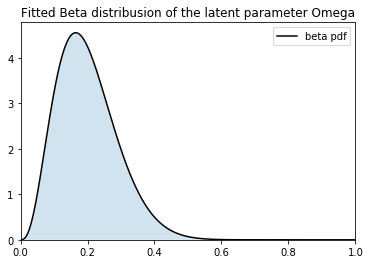

In [19]:
# plot the distribution of Omega
x = np.linspace(0, 1, 1000)
pdf = scipy.stats.beta.pdf(x, alpha, beta)

plt.plot(x, pdf, label='beta pdf', color='k')
plt.fill_between(x, 0, pdf, alpha=0.2)
plt.title('Fitted Beta distribusion of the latent parameter Omega')
plt.ylim(0)
plt.xlim(0, 1)
plt.legend()
plt.show()

In [20]:
RLV_per_customer = pd.Series(
    index=customers.index,
    data=[derl(alpha, beta, d, n) for n in range(customers.shape[0], 0, -1)]
)
RLV_per_customer

2003    3.842486
2004    3.717107
2005    3.586779
2006    3.451169
2007    3.309915
dtype: float64

In [21]:
RLV = pd.Series(
    index=customers.index,
    data=RLV_per_customer*v*customers.iloc[:, -1]
)
print(f'RLV: {int(RLV.sum())}')

RLV: 120549
